In [ ]:
# ПОДКЛЮЧЕНИЕ ДИСКА И БИБЛИОТЕК
from google.colab import drive
drive.mount('/gdrive')

import sys
sys.path.append('/gdrive/My Drive/Drafts/TEST_LSTM_Conv/')
sys.path.append('/gdrive/My Drive/Release')
import Modules.global_f as mgf
import Modules.xgb_features_selector as xgbfs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.models import Sequential, Model

Mounted at /gdrive
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# ФУНКЦИИ:
# Нормирование
def norm_df(df,  shift=1, list_rename=[], cols=[], no_cols=[]):
  df_ = df.copy()
  if cols == []:
    cols = df_.columns
  for k in cols[shift:]:
    if k not in no_cols:
      min_ = df_[k].min()
      max_ = df_[k].max()
      if k in list_rename:
          df_['n_' + k] = df_[k].apply(lambda x: (x-min_)/(max_-min_))
      else:
          df_[k] = df_[k].apply(lambda x: (x-min_)/(max_-min_))
  return df_

  #  Z преобразование
def z_df(df,  shift=1, list_rename=[], cols=[], no_cols=[]):
  df_ = df.copy()
  if cols == []:
    cols = df_.columns
  for k in cols[shift:]:
    if k not in no_cols:
      _mean = df_[k].mean()
      _std = df_[k].std()
      if k in list_rename:
          df_['z_' + k] = df_[k].apply(lambda x: (x -_mean)/_std)
      else:
          df_[k] = df_[k].apply(lambda x: (x -_mean)/_std)
  return df_

  # сдвиг с конца
def shift_from_end(xs, n):
    e = np.empty_like(xs) # массив случайных значений формы и типа xs
    if n >= 0:
        e[:-n] = xs[n:] # сдвигаем в начало на n элементоа
        e[-n:] = xs[-1:] # размещаем последний элемент на место конечных n элементов
    return e

# Функция добавляет столбцы с ifft  в датасет в соответствии с фильтрами list_comp_fft, возвращает датасет
def ifft_add_columns(df_, key_, list_comp_fft):
  _df_ = df_.copy()
  _df_.reset_index()
  close_fft = np.fft.fft(np.asarray(_df_[key_].tolist()))
  fft_df = pd.DataFrame({'fft':close_fft})
  fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
  fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
  fft_list = np.asarray(fft_df['fft'].tolist())
  #print(fft_list)
  for num_ in list_comp_fft:  # числа убирают из центра часточного распределения num_ компонент fft
    fft_list_filtered= np.copy(fft_list)
    fft_list_filtered[num_:-num_] = 0
    ifft_  = np.fft.ifft(fft_list_filtered)
    ifft_df = pd.DataFrame({'ifft':ifft_})
    ifft_df[key_ + '_'+ str(num_)+ '_ifft'] = ifft_df['ifft'].apply(lambda x: np.abs(x))
    ifft_df = ifft_df.drop(columns=['ifft'])
    _df_ = pd.concat([_df_, ifft_df], axis=1)
  return _df_

def control_wallet(yhat, open_test, target,  i):
  if yhat[0][0] > open_test[i]: # если  предсказываемая  цена закрытия больше цены открытия  - > покупаем
    vol = 1000/open_test[i]
    res =  vol*target[i] - 1000
  if yhat[0][0] < open_test[i]: # если  предсказываемая  цена закрытия   меньше  цены открытия  - > продаем
    vol = 1000/open_test[i]
    res =  1000 - vol*target[i]
  return res

In [ ]:
# ЗАГРУЗКА ДАННЫХ, ЗАПОЛНЕНИЕ ПРОПУСКОВ
DATA_PATH = '/gdrive/My Drive/Data/ALLDATA/' 
W_PATH = '/gdrive/My Drive/Drafts/TEST_LSTM_Conv/'

pd.set_option('display.max_columns', None)
df = pd.read_csv(DATA_PATH + 'df_all_scores.csv', parse_dates=[0])
df = df.interpolate(method ='linear', limit_direction ='both', limit = 50)
df.info(max_cols=1200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 536 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   Date                                                       2516 non-null   datetime64[ns]
 1   GS_Price                                                   2516 non-null   float64       
 2   GS_Open                                                    2516 non-null   float64       
 3   GS_High                                                    2516 non-null   float64       
 4   GS_Low                                                     2516 non-null   float64       
 5   GS_Vol.                                                    2516 non-null   float64       
 6   GS_Change %                                                2516 non-null   float64       
 7   GS_diffCO                       

In [ ]:
def transform_data(df, target='GS_Price', day='2020-01-01'):
  dfn = norm_df(df)

  df['d1'] = (shift_from_end(dfn[target],1)-dfn[target]) # про 25 непонятно df['d1'] = 25*(shift_from_end(dfn['GS_Price'],1)-dfn['GS_Price'])
  df['d2'] = (shift_from_end(df['d1'],1)-df['d1'])
  
  cols = ['Date', target] + ['sentiment score',	'bull score',	'bear score']  + ['d1', 'd2']  #list(best_features_n.columns)
  ifft_cols = ['sentiment score','bull score', 'bear score']

  data = df[cols]
  mask = (data['Date'] <= day) 
  data = data.loc[mask]

  for key_ in ifft_cols:  
   data = ifft_add_columns(data, key_, [12, 24])
  data = data.drop(columns=ifft_cols)

  _std =data[target].std()
  _mean = data[target].mean()
  _min = data[target].min()
  _max = data[target].max()

  zn_train_df = z_df(data, 1, [target], no_cols=['d1', 'd2'])

  return zn_train_df, _std, _mean, _min, _max

In [ ]:
def reshape_data(zn_train_df, window=64, f=1):
  x = []
  y = []
  i = 0 # счетчик
  while window + i + f  < zn_train_df.shape[0]:
    # окно - начиная со счетчика; без даты, цены и z-цены
    df_x = zn_train_df.iloc[i:window+i, 2:zn_train_df.shape[1]-1].reset_index(drop = 1)# - ntrain_df.iloc[i:window +i, 2:].reset_index(drop = 1)
    x.append(df_x.to_numpy()) #добавляем в список х массив в размере окна
    df_y = zn_train_df.iloc[window+i:window+i+f, zn_train_df.shape[1]-1].reset_index(drop = 1) # z-цена
    y.append(df_y.to_numpy())
    i += 1
  x = np.array(x)
  x_c = np.reshape(x, (-1, x.shape[1], x.shape[2], 1))
  x_l = np.reshape(x, (-1, x.shape[1], x.shape[2]))
  y = np.array(y)
  y_c = np.reshape(y, (-1, f, 1))
  y_l = np.reshape(y[:,:1], (-1, 1))
  return x, y, x_c, x_l, y_c, y_l

In [ ]:
# # порог изменения цены для продажи или покупки (пока возьму любые изменения)
# delta = 0

# df['class'] = 0
# for i in range(df.shape[0]):
#   if df['GS_diffCO'][i] / df['GS_Price'][i] > delta:
#     df['class'][i] = 1
#   elif df['GS_diffCO'][i] / df['GS_Price'][i] < -delta:
#     df['class'][i] = -1

# df.head()

In [ ]:
target = df['GS_Price'].tolist()
open_test = df['GS_Open'].tolist()

date_list = df['Date'].tolist()
df.shape, df[df['Date'] < '2020-01-01'].shape

((2516, 536), (2190, 536))

## Учим каждый раз по всем объему данных

In [ ]:
res_lstm = 0
loss_lstm = []
predictions_lstm = []

res_cnn = 0
loss_cnn = []
predictions_cnn = []

epochs = 10
cycle_num = 1 
val_point = -2

gr_c = []
gr_l = []


for i in range(2190, 2516): #2516
  print('cycle_num = ', cycle_num, i, df['Date'][i])
  zn_train_df, _std, _mean, _min, _max = transform_data(df.loc[:i], target='GS_Price', day=date_list[i])
  x, y, x_c, x_l, y_c, y_l =  reshape_data(zn_train_df)
  #print(x.shape, y.shape, x_c.shape, x_l.shape, y_c.shape, y_l.shape)
  if cycle_num == 1 :
    lstm = Sequential(name="LSTM")
    lstm.add(LSTM(1024, recurrent_regularizer='L2' , input_shape = (x.shape[1], x.shape[2]), return_sequences="True")) # 64, 32 размерноcть x
    lstm.add(LSTM(1024, recurrent_regularizer='L2')) #, return_sequences="True"))
    lstm.add(Dense(y.shape[1], activation="linear")) # target
    lstm.compile(loss="mae", optimizer="adam", metrics=['mae'])

  # на 10 эпохах попробую создать цикл (даже 20 - не хватает ресурсов)
  callback = EarlyStopping(monitor='val_mae', mode = 'min',  patience=15,  restore_best_weights=1, verbose = 1)  # patience=100 - эпохи без улучшений
  history = lstm.fit(
    x_l[:val_point], y_l[:val_point], # трехмерные данные до точки разделения, epochs=200,
    epochs=epochs,
    validation_data=(x_l[val_point:-1], y_l[val_point:-1]),
    callbacks=[callback])
  # оценка
  evaluate_lstm = lstm.evaluate(x_l[val_point:-1], y_l[val_point:-1])
  yhat_lstm = lstm.predict(x_l[-1:])* _std + _mean
  print(yhat_lstm[0][0], 'target[i] =', target[i], 'open_test[i] = ', open_test[i])
  # if yhat_lstm[0][0] > open_test[i]:
  #   vol = 1000/open_test[i]
  #   res_lstm += vol*target[i] - 1000
  # if yhat_lstm[0][0] < open_test[i]:
  #   vol = 1000/open_test[i]
  #   res_lstm += 1000 - vol*target[i]

  res_lstm += control_wallet(yhat_lstm, open_test, target, i)

  predictions_lstm.append(yhat_lstm)
  loss_lstm.append(target[i] - yhat_lstm[0][0])
  gr_l.append(yhat_lstm[0][0])
  print('lstm: ', res_lstm)
  print('')
  ############################################################
  if cycle_num == 1:
    discriminator = keras.Sequential(
      [
          keras.Input(shape=(x.shape[1], x.shape[2], 1)),
          layers.Conv2D(512, (9, 9), strides=(1, 1), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(256, (7, 7), strides=(1, 1), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(256, (3, 3), strides=(1, 1), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(y.shape[1], (3, 3), strides=(1, 1), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.GlobalMaxPooling2D(),
      ],
      name="discriminator",
    )
    #discriminator.summary()
    discriminator.compile(loss="mae", optimizer="adam", metrics=['mae'])

  callback = EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=1, verbose = 1)
  history = discriminator.fit(x_c[:val_point], y_c[:val_point], epochs=epochs, batch_size=32, validation_data=(x_c[val_point:-1], y_c[val_point:-1]), callbacks=[callback])
  evaluate_d = discriminator.evaluate(x_c[val_point:-1], y_c[val_point:-1])
  yhat_c = discriminator.predict(x_c[-1:])* _std + _mean
  print(yhat_c[0][0], 'target[i] =', target[i], 'open_test[i] = ', open_test[i])
  # if yhat_c[0][0] > open_test[i]:
  #   vol = 1000/open_test[i]
  #   res_cnn += vol*target[i] - 1000
  # if yhat_c[0][0] < open_test[i]:
  #   vol = 1000/open_test[i]
  #   res_cnn += 1000 - vol*target[i]

  res_cnn += control_wallet(yhat_c, open_test, target, i) # def control_wallet(y_hat, open_test, target,  i):

  predictions_cnn.append(yhat_c[0][0])
  gr_c.append(yhat_c[0][0])
  loss_cnn.append(target[i] - yhat_c[0][0])
  print('cnn: ', res_cnn)
  cycle_num += 1
  print('')
  print('<!>'*50)
  print('')

cycle_num =  1 2190 2020-01-02 00:00:00
Epoch 1/10
67/67 [==============================] - 7s 76ms/step - loss: 4.2539 - mae: 0.5206 - val_loss: 0.4423 - val_mae: 0.2704
Epoch 2/10
67/67 [==============================] - 4s 59ms/step - loss: 0.4497 - mae: 0.3803 - val_loss: 0.5639 - val_mae: 0.4828
Epoch 3/10
67/67 [==============================] - 4s 59ms/step - loss: 0.4746 - mae: 0.3790 - val_loss: 0.0974 - val_mae: 0.0382
Epoch 4/10
67/67 [==============================] - 4s 59ms/step - loss: 0.3539 - mae: 0.3098 - val_loss: 0.1758 - val_mae: 0.1488
Epoch 5/10
67/67 [==============================] - 4s 59ms/step - loss: 0.3064 - mae: 0.2796 - val_loss: 0.2835 - val_mae: 0.2557
Epoch 6/10
67/67 [==============================] - 4s 60ms/step - loss: 0.2871 - mae: 0.2605 - val_loss: 0.0738 - val_mae: 0.0385
Epoch 7/10
67/67 [==============================] - 4s 60ms/step - loss: 0.2730 - mae: 0.2443 - val_loss: 0.6512 - val_mae: 0.6002
Epoch 8/10
67/67 [=========================

KeyboardInterrupt: ignored

In [ ]:
gr_l

[226.2016]

## Вариант когда учим только по новым данным

In [ ]:
res_lstm = 0
loss_lstm = []
predictions_lstm = []

res_cnn = 0
loss_cnn = []
predictions_cnn = []

epochs = 15
cycle_num = 1 
val_point = -2
gr_c = []
gr_l = []

for i in range(2190, 2516): #2516
  print('cycle_num = ', cycle_num, i, df['Date'][i])
  zn_train_df, _std, _mean, _min, _max = transform_data(df.loc[:i], target='GS_Price', day=date_list[i])
  x, y, x_c, x_l, y_c, y_l =  reshape_data(zn_train_df)
  #print(x.shape, y.shape, x_c.shape, x_l.shape, y_c.shape, y_l.shape)
  if cycle_num == 1 :
    lstm = Sequential(name="LSTM")
    lstm.add(LSTM(1024, recurrent_regularizer='L2' , input_shape = (x.shape[1], x.shape[2]), return_sequences="True")) # 64, 32 размерноcть x
    lstm.add(LSTM(1024, recurrent_regularizer='L2')) #, return_sequences="True"))
    lstm.add(Dense(y.shape[1], activation="linear")) # target
    lstm.compile(loss="mae", optimizer="adam", metrics=['mae'])

    # на 10 эпохах попробую создать цикл (даже 20 - не хватает ресурсов)
    callback = EarlyStopping(monitor='val_mae', mode = 'min',  patience=15,  restore_best_weights=1, verbose = 1)  # patience=100 - эпохи без улучшений
    history = lstm.fit(
      x_l[:val_point], y_l[:val_point], # трехмерные данные до точки разделения, epochs=200,
      epochs=epochs,
      validation_data=(x_l[val_point:-1], y_l[val_point:-1]),
      callbacks=[callback])
  # оценка
  else:
      history = lstm.fit(
      x_l[val_point:-1], y_l[val_point:-1], # трехмерные данные до точки разделения, epochs=200,
      epochs=1,
      validation_data=(x_l[val_point:-1], y_l[val_point:-1]), 
      verbose = 0)
  evaluate_lstm = lstm.evaluate(x_l[val_point:-1], y_l[val_point:-1],  verbose = 0)
  yhat_lstm = lstm.predict(x_l[-1:])* _std + _mean
  print(yhat_lstm, 'target[i] =', target[i], 'open_test[i] = ', open_test[i])
  # if yhat_lstm[0][0] > open_test[i]:
  #   vol = 1000/open_test[i]
  #   res_lstm += vol*target[i] - 1000
  # if yhat_lstm[0][0] < open_test[i]:
  #   vol = 1000/open_test[i]
  #   res_lstm += 1000 - vol*target[i]

  res_lstm += control_wallet(yhat_lstm, open_test, target, i)

  predictions_lstm.append(yhat_lstm)
  loss_lstm.append(target[i] - yhat_lstm[0][0])
  gr_l.append(yhat_lstm[0][0])
  print('lstm: ', res_lstm)
  print('')
  ############################################################
  if cycle_num == 1:
    discriminator = keras.Sequential(
      [
          keras.Input(shape=(x.shape[1], x.shape[2], 1)),
          layers.Conv2D(512, (9, 9), strides=(1, 1), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(256, (7, 7), strides=(1, 1), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(256, (3, 3), strides=(1, 1), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(y.shape[1], (3, 3), strides=(1, 1), padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.GlobalMaxPooling2D(),
      ],
      name="discriminator",
    )
    #discriminator.summary()
    discriminator.compile(loss="mae", optimizer="adam", metrics=['mae'])
    callback = EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=1, verbose = 1)
    history = discriminator.fit(x_c[:val_point], y_c[:val_point], epochs=epochs, batch_size=32, validation_data=(x_c[val_point:-1], y_c[val_point:-1]), callbacks=[callback])
  else:
    history = discriminator.fit(x_c[val_point:-1], y_c[val_point:-1], epochs=1, batch_size=32, validation_data=(x_c[val_point:-1], y_c[val_point:-1]), verbose = 0)
  evaluate_d = discriminator.evaluate(x_c[val_point:-1], y_c[val_point:-1],  verbose = 0)
  yhat_c = discriminator.predict(x_c[-1:])* _std + _mean
  print(yhat_c, 'target[i] =', target[i], 'open_test[i] = ', open_test[i])
  # if yhat_c[0][0] > open_test[i]:
  #   vol = 1000/open_test[i]
  #   res_cnn += vol*target[i] - 1000
  # if yhat_c[0][0] < open_test[i]:
  #   vol = 1000/open_test[i]
  #   res_cnn += 1000 - vol*target[i]

  res_cnn += control_wallet(yhat_c, open_test, target, i) # def control_wallet(y_hat, open_test, target,  i):

  predictions_cnn.append(yhat_c[0][0])
  loss_cnn.append(target[i] - yhat_c[0][0])
  gr_c.append(yhat_c[0][0])
  print('cnn: ', res_cnn)
  cycle_num += 1
  
  print('')
  print('<!>'*50)
  print('')

cycle_num =  1 2190 2020-01-02 00:00:00
Epoch 1/15
67/67 [==============================] - 7s 70ms/step - loss: 4.5268 - mae: 0.5247 - val_loss: 0.6387 - val_mae: 0.3831
Epoch 2/15
67/67 [==============================] - 4s 60ms/step - loss: 0.4710 - mae: 0.3735 - val_loss: 0.0506 - val_mae: 0.0194
Epoch 3/15
67/67 [==============================] - 4s 60ms/step - loss: 0.3988 - mae: 0.3602 - val_loss: 0.0940 - val_mae: 0.0472
Epoch 4/15
67/67 [==============================] - 4s 60ms/step - loss: 0.3958 - mae: 0.3486 - val_loss: 0.0992 - val_mae: 0.0023
Epoch 5/15
67/67 [==============================] - 4s 61ms/step - loss: 0.3661 - mae: 0.3221 - val_loss: 0.3987 - val_mae: 0.3694
Epoch 6/15
67/67 [==============================] - 4s 61ms/step - loss: 0.3467 - mae: 0.3108 - val_loss: 0.1285 - val_mae: 0.0976
Epoch 7/15
67/67 [==============================] - 4s 61ms/step - loss: 0.2745 - mae: 0.2435 - val_loss: 0.3955 - val_mae: 0.3634
Epoch 8/15
67/67 [=========================

In [ ]:
# обучение модели на данных до 2020 года
# предсказание первой точки года (~01.01.20)
# сравнение с открытием, решение-действие, сравнение с реальным, сохранение прибыли/убытка
# добавление первой точки теста в массив, нормирование, фурье, преобразование данных в 3- и 4-мерный формат, обучение 
# (на последнем батче или на всем массиве?) - ??
print(res_lstm)
print(res_cnn)

75.97188059599205
116.47184952868417


In [ ]:
# I found my problem was because of multi-threading. I added an empty predict() call before launching threads and the retrace warning was gone.
#####
# I solved this issue by replacing model.fit() with for loop, just like this:
# At first, my model.fit():
# yoro_model.fit(x=my_train_batch_generator, steps_per_epoch=int(len(files_path_list_train) // BATCH_SIZE), epochs=EPOCH, verbose=1, workers= 48, validation_data = my_test_batch_generator, validation_steps=int(len(files_path_list_test)//BATCH_SIZE) )

# after changing the code above to code below:
# num_batches = int(len(files_path_list_train) // BATCH_SIZE) num_val = int(len(files_path_list_test) // BATCH_SIZE) optimizer = tf.keras.optimizers.Adam() for i in range(EPOCH): print("\n----------epoch %d "%i) for batch_index in range(num_batches): X, Y = my_train_batch_generator.__getitem__(batch_index) # Y = Y.astype('float32') with tf.GradientTape() as tape: tape.watch(yoro_model.variables) y_pred = yoro_model(X) loss = yoro_loss(y_true=Y, y_pred=y_pred) print("batch %d : train loss %f"%(batch_index,loss.numpy())) grads = tape.gradient(loss, yoro_model.variables) optimizer.apply_gradients(grads_and_vars=zip(grads,yoro_model.variables)) # validation for val_batch_index in range(num_val): X_val, Y_val = my_test_batch_generator.__getitem__(val_batch_index) y_val_pred = yoro_model(X_val) val_loss = yoro_loss(y_true=Y_val, y_pred=y_val_pred) print("batch %d : val loss %f"%(val_batch_index,val_loss.numpy()))
# the WARNING disappeared.

# Hope it helps!

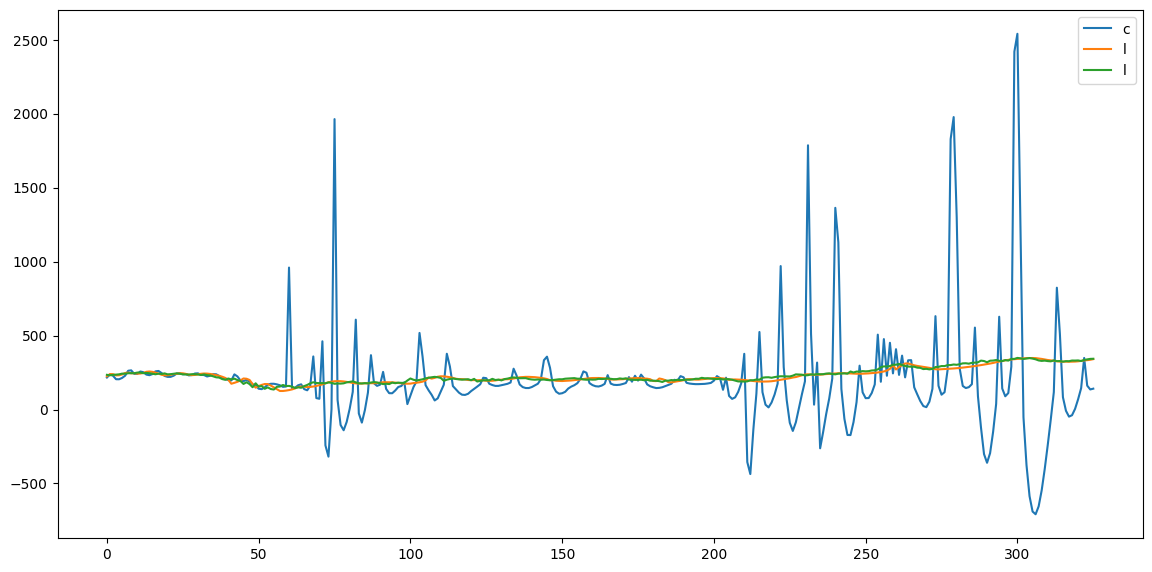

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(gr_c, label='c')
plt.plot(gr_l, label='l')
plt.plot(target[2190:], label='t')
#plt.title('Figure #:' + KEY)
plt.legend()
plt.show()